In [ ]:
from keras.models import Sequential
import numpy as np
from keras.layers import Dense
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# đọc dữ liệu và tiền xử lý
data = pd.read_csv('https://raw.githubusercontent.com/huy164/datasets/master/walmart_stock_price.csv')

# Chuyển đổi cột ngày sang định dạng datetime
data['Date'] = pd.to_datetime(data['Date'])

# Chia tập dữ liệu thành train, validate và test theo tỉ lệ 60-25-15
train_size = 0.6
val_size = 0.15
test_size = 0.25

X = data.index.values
y = data['Close'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size/(train_size+val_size), shuffle=False)

# Chuẩn bị dữ liệu
def prepare_data(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 3
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

X_train_idx = data.iloc[X_train].index
X_train, y_train = prepare_data(data.loc[X_train_idx, ['Close']].values, window_size)
X_val_idx = data.iloc[X_val].index
X_val, y_val = prepare_data(data.loc[X_val_idx, ['Close']].values, window_size)
X_test_idx = data.iloc[X_test].index
X_test, y_test = prepare_data(data.loc[X_test_idx, ['Close']].values, window_size)

# Khởi tạo scaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Xây dựng và biên dịch mô hình NNAR
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(window_size,)))
model.add(Dense(window_size))
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện và đánh giá mô hình NNAR
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1)

Epoch 1/50
235/235 [==============================] - 1s 3ms/step - loss: 367.0812 - val_loss: 7968.4990
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 289.3249 - val_loss: 186158.2188
Epoch 3/50
235/235 [==============================] - 1s 2ms/step - loss: 194.2817 - val_loss: 768745.0000
Epoch 4/50
235/235 [==============================] - 1s 6ms/step - loss: 125.2740 - val_loss: 1754373.1250
Epoch 5/50
235/235 [==============================] - 1s 5ms/step - loss: 85.1835 - val_loss: 3010270.5000
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 56.3294 - val_loss: 4560360.0000
Epoch 7/50
235/235 [==============================] - 1s 5ms/step - loss: 33.7733 - val_loss: 6282959.5000
Epoch 8/50
235/235 [==============================] - 1s 5ms/step - loss: 17.3272 - val_loss: 8074140.5000
Epoch 9/50
235/235 [==============================] - 2s 7ms/step - loss: 7.4012 - val_loss: 9682229.0000
Epoch 10/50
235/235 [==================

In [ ]:
# Test model
test_loss = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)

# Kiểm tra test loss trên train của model
test_loss_train = model.evaluate(X_train, y_train)
print('Test Loss train:', test_loss_train)

# Dự đoán giá trị đầu ra của mô hình trên tập dữ liệu kiểm tra
predictions = model.predict(X_test)

# Chuyển đổi giá trị đầu ra từ dạng chuẩn hóa về dạng gốc
predictions = scaler.inverse_transform(predictions)

# Lấy giá trị thực tế của tập dữ liệu kiểm tra
true_value = scaler.inverse_transform(np.tile(y_test.reshape(-1, 1), 3))

# Tính toán RMSE trên kết quả dự đoán và giá trị thực tế
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(true_value, predictions, squared=False)
rmse = np.sqrt(mse)
# In ra giá trị RMSE
print("RMSE:", rmse)

from sklearn.metrics import r2_score
r2 = r2_score(true_value, predictions)
print('R-squared:', r2)

from keras.losses import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(true_value, predictions)
print('MAPE:', mape)

98/98 [==============================] - 0s 1ms/step - loss: 1.7850
Test Loss: 1.785019874572754
235/235 [==============================] - 0s 1ms/step - loss: 0.3465
Test Loss train: 0.3465413451194763
98/98 [==============================] - 0s 1ms/step
RMSE: 9.630719617936911
R-squared: 0.9977863492535701
MAPE: tf.Tensor([1.9616163  1.5589265  2.2987187  ... 0.45625478 0.14840554 0.12936085], shape=(3122,), dtype=float32)


98/98 [==============================] - 0s 1ms/step


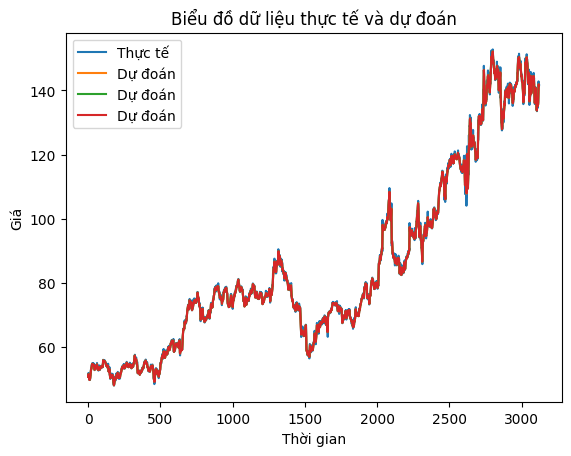

In [ ]:
import matplotlib.pyplot as plt

# Dự đoán giá trị trên tập dữ liệu kiểm tra
y_pred = model.predict(X_test)

# Cắt các mẫu dữ liệu dự đoán sao cho có cùng chiều dài với dữ liệu thực tế
y_pred_cut = y_pred[window_size-1:]

# Vẽ biểu đồ cho dữ liệu thực tế và dự đoán
plt.plot(y_test, label='Thực tế')
plt.plot(y_pred_cut, label='Dự đoán')
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.title('Biểu đồ dữ liệu thực tế và dự đoán')
plt.legend()
plt.show()